In [1]:
# Import libraries
import os
import glob
import random
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from brain_dataset import BrainDataset
from brain_dataset import set_seed, dataset_info, print_model_architecture
from unet_architecture import UNet
from attention_gate import AttentionUNet

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
import torchvision.transforms as tt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
# Cpu or Gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


# Load files

In [3]:
BASE_PATH = 'input/lgg-mri-segmentation/kaggle_3m/'

mask_files = glob.glob(BASE_PATH + '*/*_mask*')
image_files = [file.replace('_mask', '') for file in mask_files]

def diagnosis(mask_path):
    return 1 if np.max(cv2.imread(mask_path)) > 0 else 0

data_df = pd.DataFrame({"image_path": image_files,
                  "mask_path": mask_files,
                  "diagnosis": [diagnosis(x) for x in mask_files]})

data_df

,image_path,mask_path,diagnosis
0,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,0
1,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,0
2,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,0
3,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,0
4,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6...,0
...,...,...,...
3924,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,0
3925,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,0
3926,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,0
3927,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A...,0


## Plotting the data

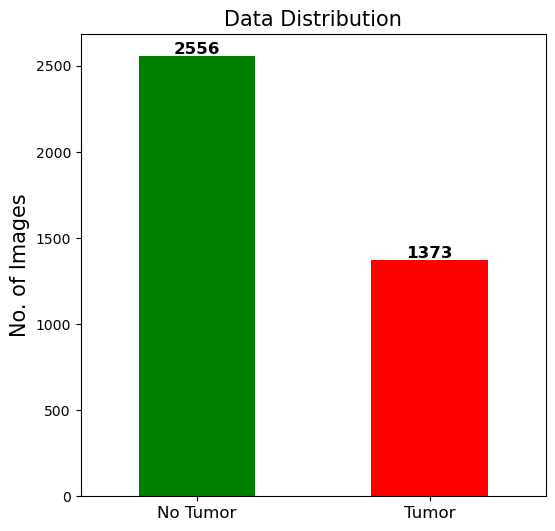

In [4]:

ax = data_df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(6,6), color=['green', 'red'])
ax.set_title('Data Distribution', fontsize=15)
ax.set_ylabel('No. of Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(data_df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=12)

## Split dataset

In [5]:
train_df, val_df = train_test_split(data_df, stratify=data_df['diagnosis'], test_size=0.1, random_state=0)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df['diagnosis'], test_size=0.15, random_state=0)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Train: {}\nVal: {}\nTest: {}".format(train_df.shape, val_df.shape, test_df.shape))

Train: (3005, 3)
Val: (393, 3)
Test: (531, 3)


(-0.5, 1279.5, 255.5, -0.5)

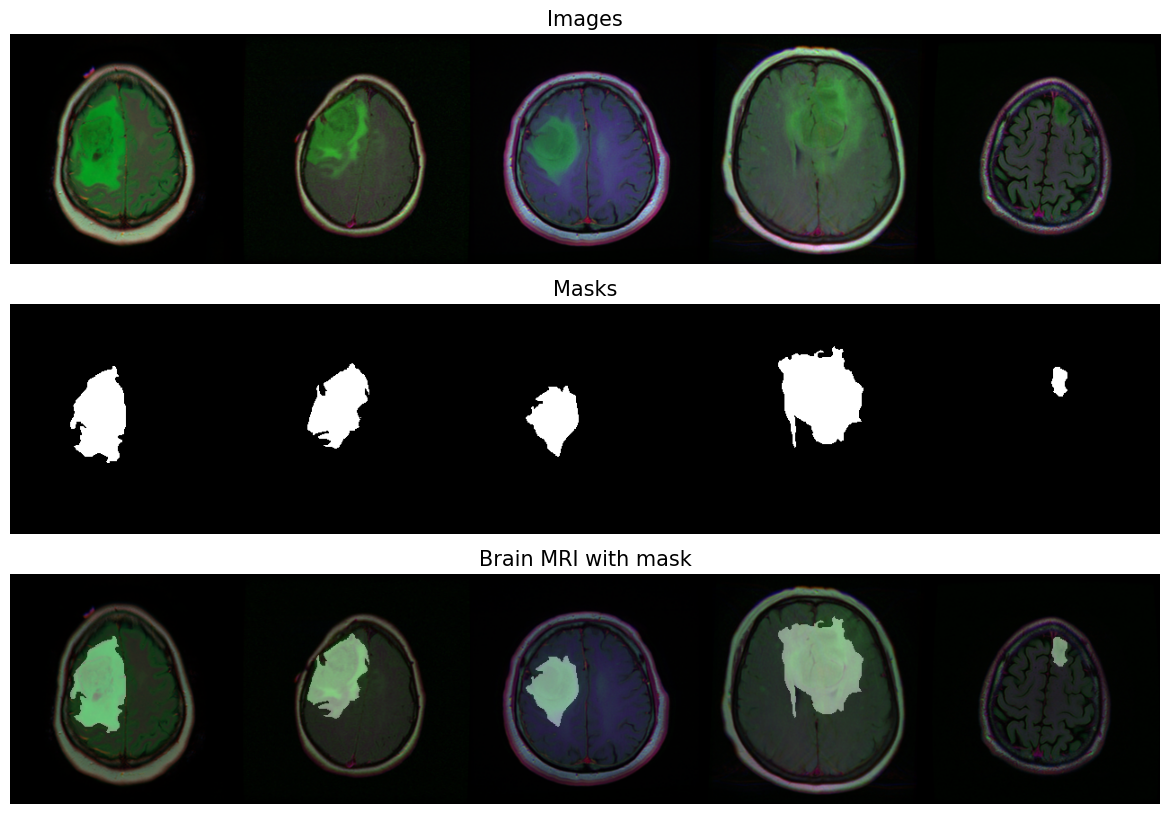

In [6]:
set_seed()

# Figure for images and masks for positive diagnosis
images, masks = [], []
df_positive = train_df[train_df['diagnosis']==1].sample(5).values

for sample in df_positive:
    img = cv2.imread(sample[0])
    mask = cv2.imread(sample[1])
    images.append(img)
    masks.append(mask)
images = np.hstack(np.array(images))
masks = np.hstack(np.array(masks))

fig = plt.figure(figsize=(15,10))
grid = ImageGrid(fig, 111, nrows_ncols=(3,1), axes_pad=0.4)

grid[0].imshow(images)
grid[0].set_title('Images', fontsize=15)
grid[0].axis('off')
grid[1].imshow(masks)
grid[1].set_title('Masks', fontsize=15)
grid[1].axis('off')
grid[2].imshow(images)
grid[2].imshow(masks, alpha=0.4)
grid[2].set_title('Brain MRI with mask', fontsize=15)
grid[2].axis('off')

# Pytorch dataset format

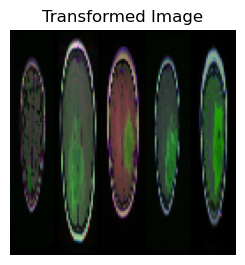

In [7]:
train_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
])

val_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0),
    A.HorizontalFlip(p=0.5),
])

test_transform = A.Compose([
    A.Resize(width=128, height=128, p=1.0)
])

transformed_image = train_transform(image=images)['image']

# Plotting the transformed image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title('Transformed Image')
plt.axis('off')

plt.show()

In [8]:
set_seed()

train_ds = BrainDataset(train_df, train_transform)
val_ds = BrainDataset(val_df, val_transform)
test_ds = BrainDataset(test_df, test_transform)


In [9]:
print('Train dataset:')
dataset_info(train_ds)
print('Validation dataset:')
dataset_info(val_ds)
print('Test dataset:')
dataset_info(test_ds)

Train dataset:
Size of dataset: 3005
Sample-25 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Validation dataset:
Size of dataset: 393
Sample-23 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])

Test dataset:
Size of dataset: 531
Sample-19 Image size: torch.Size([3, 128, 128]), Mask: torch.Size([1, 128, 128])



# Creating dataloaders

In [10]:
batch_size = 64

set_seed()
train_dataloader = DataLoader(train_ds, 
                      batch_size, 
                      shuffle=True, 
                      num_workers=2,  
                      pin_memory=True)  

set_seed()
val_dataloader = DataLoader(val_ds, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)

test_dataloader = DataLoader(val_ds, 
                    batch_size,   
                    num_workers=2, 
                    pin_memory=True)

In [11]:
images, masks = next(iter(train_dataloader))
print(images.shape)
print(masks.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64, 1, 128, 128])


## Viewing samples from a batch

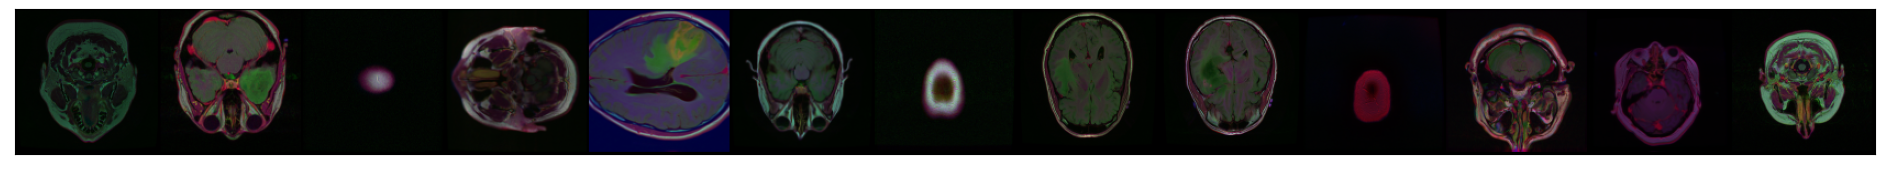

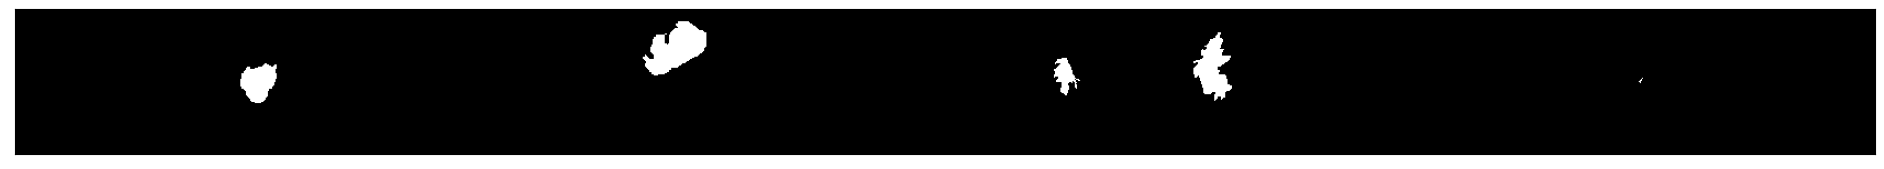

In [14]:
def denormalize(images):
    means = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, masks in dl:
        fig1, ax1 = plt.subplots(figsize=(24, 24))
        ax1.set_xticks([]); ax1.set_yticks([])
        denorm_images = denormalize(images)
        ax1.imshow(make_grid(denorm_images[:13], nrow=13).permute(1, 2, 0).clamp(0,1))
        
        fig2, ax2 = plt.subplots(figsize=(24, 24))
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[:13], nrow=13).permute(1, 2, 0).clamp(0,1))
        break
        
show_batch(train_dataloader)

# Metric & Loss functions

In [15]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if pred.sum() == 0 and label.sum() == 0:
        return 1.
    return intersection / union

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    return dice_loss + bce_loss

The Dice coefficient measures the similarity between two binary masks and is commonly used in image segmentation tasks.These functions are often used when training deep learning models for image segmentation tasks. During training, the model is optimized to minimize the combined loss (bce_dice_loss), which encourages both accurate pixel-wise predictions and accurate delineation of object boundaries. The dice_coef_metric function can be used to evaluate the model's performance during validation or testing by computing the Dice coefficient between predicted and ground truth masks.

# Training

In [16]:
def train_loop(model, loader, loss_func, optimizer, device):
    model.train()
    train_losses = []
    train_dices = []
    
    for i, (image, mask) in enumerate(loader):
        image, mask = image.to(device), mask.to(device)
        
        optimizer.zero_grad()
        outputs = model(image)
        # Apply sigmoid to get values between 0 and 1
        outputs = torch.sigmoid(outputs)

        predicted_mask = (outputs >= 0.5).float()  
        
        loss = loss_func(outputs, mask)
        dice = dice_coef_metric(predicted_mask, mask)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        train_dices.append(dice)
        
        print(f'Batch [{i+1}/{len(loader)}], Loss: {loss.item()}, Dice Coefficient: {dice}')
        
    return train_dices, train_losses


The attention mechanism can produce attention maps or coefficients that are not necessarily bounded between 0 and 1. The values in these maps can be positive or negative, and they represent the importance or relevance of different spatial regions in the input feature maps.

The Dice coefficient is a statistical metric used to quantify the similarity or overlap between two sets or regions. 
A Dice coefficient of 0 indicates no overlap or dissimilarity between the predicted and ground truth masks.
A Dice coefficient of 1 indicates perfect overlap and complete similarity between the predicted and ground truth masks.

In [17]:
def eval_loop(model, loader, loss_func, device, training=True):
    model.eval()
    val_loss = 0
    val_dice = 0
    
    with torch.no_grad():
        for step, (image, mask) in enumerate(loader):
            image, mask = image.to(device), mask.to(device)
    
            outputs = model(image)
            # Apply sigmoid to get values between 0 and 1
            outputs = torch.sigmoid(outputs)
            
            predicted_mask = (outputs >= 0.5).float()  
            dice = dice_coef_metric(predicted_mask, mask)
            
            loss = loss_func(outputs, mask)  
            
            val_loss += loss.item()
            val_dice += dice.item()
            
            # Print batch information
            print(f'Validation Batch [{step+1}/{len(loader)}], Loss: {loss.item()}, Dice Coefficient: {dice.item()}')
        
        val_mean_dice = val_dice / (step + 1) 
        val_mean_loss = val_loss / (step + 1)  
        
        if training:
            scheduler.step(val_mean_dice)
        
    return val_mean_dice, val_mean_loss


In [18]:
def train_model(model, train_loader, val_loader, loss_func, optimizer, scheduler, num_epochs, device):
    train_loss_history = []
    train_dice_history = []
    val_loss_history = []
    val_dice_history = []
    
    for epoch in range(num_epochs):
        # Training
        train_dices, train_losses = train_loop(model, train_loader, loss_func, optimizer, device)
        train_mean_dice = np.array(train_dices).mean()
        train_mean_loss = np.array(train_losses).mean()
        
        # Validation
        val_mean_dice, val_mean_loss = eval_loop(model, val_loader, loss_func, device)
        
        # Record history
        train_loss_history.append(train_mean_loss)
        train_dice_history.append(train_mean_dice)
        val_loss_history.append(val_mean_loss)
        val_dice_history.append(val_mean_dice)
        
        # Adjust learning rate if using a scheduler
        if scheduler is not None:
            scheduler.step(val_mean_dice)
        
        # Print epoch information
        print('Epoch: {}/{} | Train Loss: {:.3f} | Val Loss: {:.3f} | Train DICE: {:.3f} | Val DICE: {:.3f}'.format(
            epoch+1, num_epochs, train_mean_loss, val_mean_loss, train_mean_dice, val_mean_dice))
    
    return train_loss_history, train_dice_history, val_loss_history, val_dice_history


# UNet Model

In [17]:
# UNET Model
model = UNet(3, 1).to(device)
out = model(torch.randn(1, 3, 128, 128).to(device))
print(out.shape)
print_model_architecture(model)

torch.Size([1, 1, 128, 128])
UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): Batch

In [38]:
import itertools

"""Test för att se om allt funkar"""
# Define the number of batches to use for testing
num_test_batches = 2  # Adjust this to your desired number of batches

# Create a subset of the data loader for testing
test_train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

# Extract a smaller portion of the data loaders for testing and convert to a list
test_train_dl = list(itertools.islice(test_train_dl, num_test_batches))
test_val_dl = list(itertools.islice(test_val_dl, num_test_batches))

# Define your optimizer, scheduler, and number of epochs as before
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 3

print("Training starts")
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(
    model, test_train_dl, test_val_dl, bce_dice_loss, optimizer, scheduler, num_epochs, device)

Training starts
Batch [1/2], Loss: 1.898280143737793, Dice Coefficient: 0.02208464965224266
Batch [2/2], Loss: 1.8869280815124512, Dice Coefficient: 0.02007911540567875
Validation Batch [1/2], Loss: 1.9389188289642334, Dice Coefficient: 0.017694832757115364
Validation Batch [2/2], Loss: 1.9428071975708008, Dice Coefficient: 0.014481776393949986
Epoch: 1/3 | Train Loss: 1.893 | Val Loss: 1.941 | Train DICE: 0.021 | Val DICE: 0.016
Batch [1/2], Loss: 1.8673571348190308, Dice Coefficient: 0.02208464965224266
Batch [2/2], Loss: 1.8488980531692505, Dice Coefficient: 0.02007911540567875
Validation Batch [1/2], Loss: 1.917210578918457, Dice Coefficient: 0.017694832757115364
Validation Batch [2/2], Loss: 1.921433925628662, Dice Coefficient: 0.014481776393949986
Epoch: 2/3 | Train Loss: 1.858 | Val Loss: 1.919 | Train DICE: 0.021 | Val DICE: 0.016
Batch [1/2], Loss: 1.83546781539917, Dice Coefficient: 0.02208464965224266
Batch [2/2], Loss: 1.8227956295013428, Dice Coefficient: 0.020079115405678

In [38]:
""" Träning"""
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 1

print("Training starts")
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(
    model, train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs, device)

Training starts
Batch [1/47], Loss: 1.9170100688934326, Dice Coefficient: 0.02032395638525486


KeyboardInterrupt: 

## UNet results

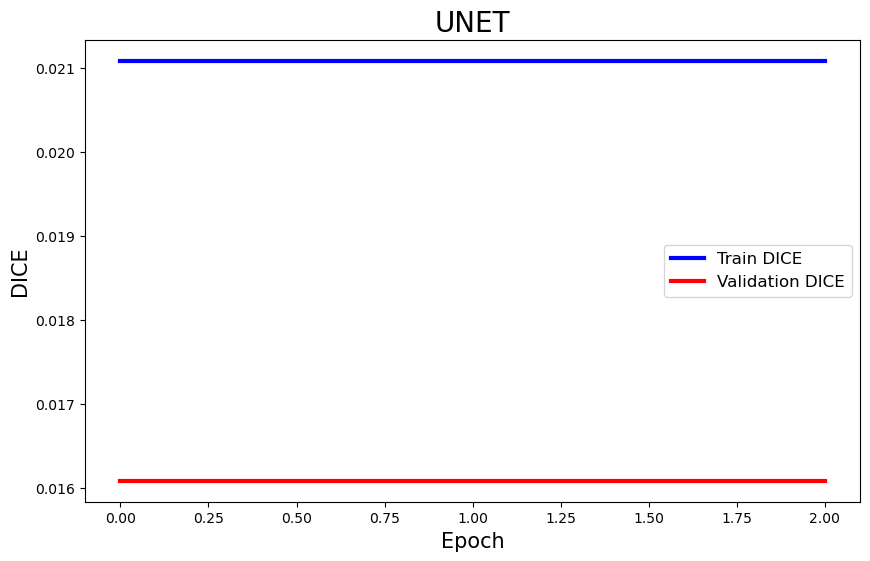

In [39]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    
plot_dice_history('UNET', train_dice_history, val_dice_history, num_epochs)

A higher Dice coefficient indicates better agreement between the predicted and ground truth masks. In the context of image segmentation, you want the Dice coefficient to increase during training, as this means that the model's predictions are becoming more accurate and aligning better with the ground truth.

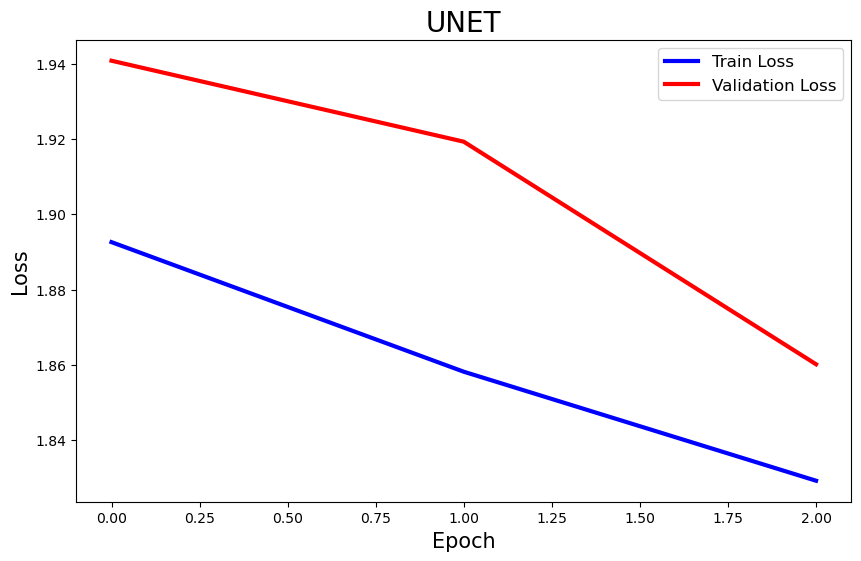

In [40]:
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="b")
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()
    
plot_loss_history('UNET', train_loss_history, val_loss_history, num_epochs)

## UNet: Test on testset

In [42]:

# Evaluate the model on the test set
test_dice, test_loss = eval_loop(model, test_dataloader, bce_dice_loss, device=device, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100 * test_dice), test_loss))

Validation Batch [1/9], Loss: 1.8635914325714111, Dice Coefficient: 0.016059575602412224
Validation Batch [2/9], Loss: 1.8506965637207031, Dice Coefficient: 0.022431563585996628
Validation Batch [3/9], Loss: 1.8507695198059082, Dice Coefficient: 0.024532826617360115
Validation Batch [4/9], Loss: 1.8442490100860596, Dice Coefficient: 0.02817521244287491
Validation Batch [5/9], Loss: 1.8602819442749023, Dice Coefficient: 0.016177810728549957
Validation Batch [6/9], Loss: 1.863267421722412, Dice Coefficient: 0.016549311578273773
Validation Batch [7/9], Loss: 1.8542125225067139, Dice Coefficient: 0.0201520137488842
Validation Batch [8/9], Loss: 1.8540737628936768, Dice Coefficient: 0.023346757516264915
Validation Batch [9/9], Loss: 1.8575575351715088, Dice Coefficient: 0.018743576481938362
Mean IoU/DICE: 2.069%, Loss: 1.855


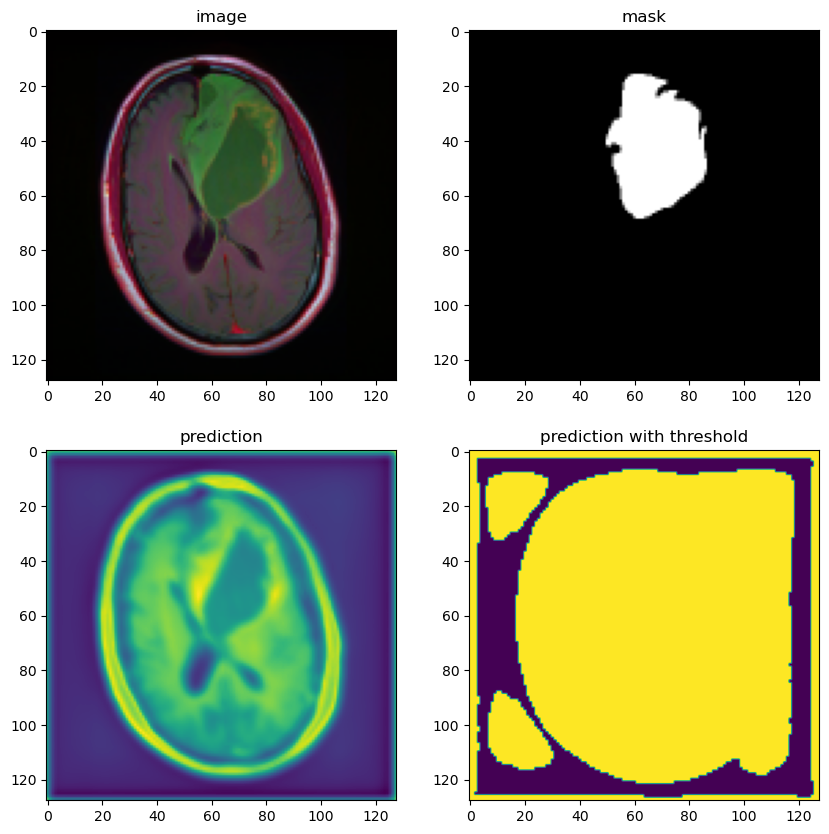

In [43]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# Predicted 
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# Plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()

# Attention Gate Model

In [20]:
attention_unet = AttentionUNet(n_classes=1).to(device)
output = torch.randn(1,3,256,256).to(device)
print(output.shape)
print_model_architecture(attention_unet)

torch.Size([1, 3, 256, 256])
AttentionUNet(
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [22]:
import itertools

"""Test för att se om allt funkar"""
# Define the number of batches to use for testing
num_test_batches = 2  

# Create a subset of the data loader for testing
test_train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

# Extract a smaller portion of the data loaders for testing and convert to a list
test_train_dl = list(itertools.islice(test_train_dl, num_test_batches))
test_val_dl = list(itertools.islice(test_val_dl, num_test_batches))

# Define your optimizer, scheduler, and number of epochs as before
optimizer = torch.optim.Adam(attention_unet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs = 3

print("Training starts")
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(
    attention_unet, test_train_dl, test_val_dl, bce_dice_loss, optimizer, scheduler, num_epochs, device)

Training starts
Batch [1/2], Loss: 1.5181050300598145, Dice Coefficient: 0.08068905025720596
Batch [2/2], Loss: 1.4822735786437988, Dice Coefficient: 0.13120326399803162
Validation Batch [1/2], Loss: 8.893742561340332, Dice Coefficient: 0.017754172906279564
Validation Batch [2/2], Loss: 8.913444519042969, Dice Coefficient: 0.014531166292726994
Epoch: 1/3 | Train Loss: 1.500 | Val Loss: 8.904 | Train DICE: 0.106 | Val DICE: 0.016
Batch [1/2], Loss: 1.3756141662597656, Dice Coefficient: 0.3871857225894928
Batch [2/2], Loss: 1.3219289779663086, Dice Coefficient: 0.24223634600639343
Validation Batch [1/2], Loss: 81.18284606933594, Dice Coefficient: 0.017790889367461205
Validation Batch [2/2], Loss: 80.98114776611328, Dice Coefficient: 0.014564816839993
Epoch: 2/3 | Train Loss: 1.349 | Val Loss: 81.082 | Train DICE: 0.315 | Val DICE: 0.016
Batch [1/2], Loss: 1.3163822889328003, Dice Coefficient: 0.19711677730083466
Batch [2/2], Loss: 1.283488392829895, Dice Coefficient: 0.4133467674255371
V

In [19]:
"""Träningen för Attention Gate"""""
optimizer = torch.optim.Adam(attention_unet.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)
num_epochs  = 3

print("Training starts")
train_loss_history, train_dice_history, val_loss_history, val_dice_history = train_model(
    attention_unet, train_dataloader, val_dataloader, bce_dice_loss, optimizer, scheduler, num_epochs, device)

Training starts
Batch [1/47], Loss: 1.6574997901916504, Dice Coefficient: 0.01730894297361374
Batch [2/47], Loss: 1.6191941499710083, Dice Coefficient: 0.06502433866262436
Batch [3/47], Loss: 1.5260659456253052, Dice Coefficient: 0.04172351583838463
Batch [4/47], Loss: 1.4450416564941406, Dice Coefficient: 0.1020934209227562
Batch [5/47], Loss: 1.3392019271850586, Dice Coefficient: 0.3624037802219391
Batch [6/47], Loss: 1.3199882507324219, Dice Coefficient: 0.4126844108104706
Batch [7/47], Loss: 1.3174316883087158, Dice Coefficient: 0.35482707619667053
Batch [8/47], Loss: 1.270659327507019, Dice Coefficient: 0.5224453806877136
Batch [9/47], Loss: 1.2649153470993042, Dice Coefficient: 0.3876257538795471
Batch [10/47], Loss: 1.25246000289917, Dice Coefficient: 0.4671219289302826
Batch [11/47], Loss: 1.2543777227401733, Dice Coefficient: 0.35565051436424255
Batch [12/47], Loss: 1.2824307680130005, Dice Coefficient: 0.2590002417564392
Batch [13/47], Loss: 1.2424006462097168, Dice Coefficie

RuntimeError: all elements of input should be between 0 and 1

## Attention Gate results

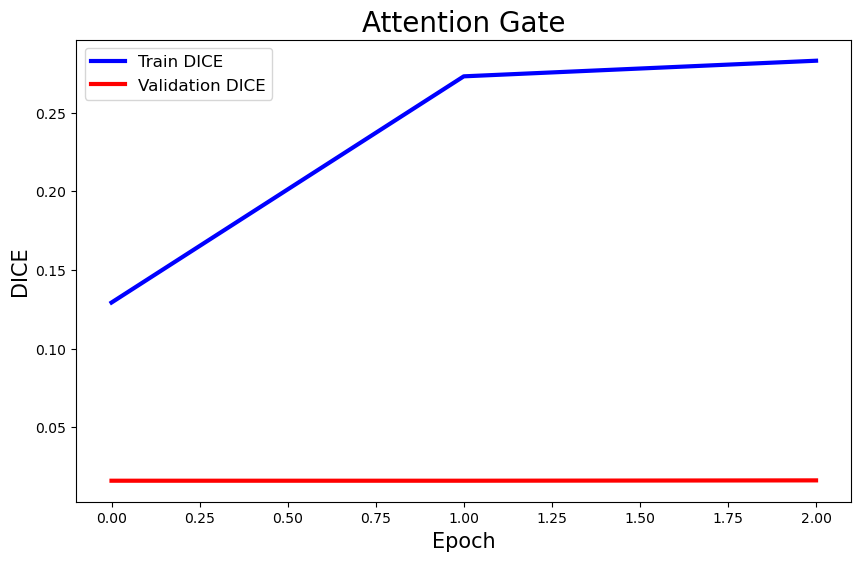

In [32]:
def plot_dice_history(model_name, train_dice_history, val_dice_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_dice_history, label='Train DICE', lw=3, c="b")
    plt.plot(x, val_dice_history, label='Validation DICE', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("DICE", fontsize=15)

    plt.show()
    
plot_dice_history('Attention Gate', train_dice_history, val_dice_history, num_epochs)

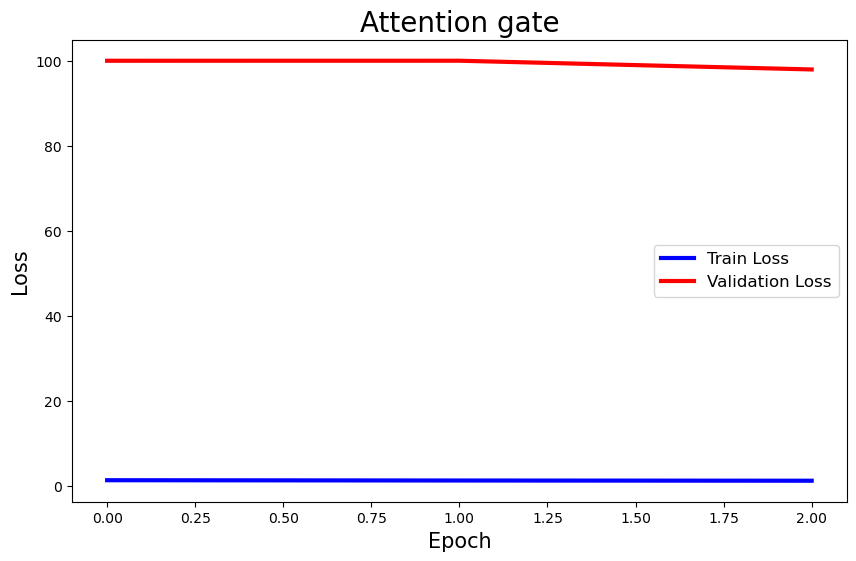

In [33]:
def plot_loss_history(model_name, train_loss_history, val_loss_history, num_epochs):
    
    x = np.arange(num_epochs)
    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_loss_history, label='Train Loss', lw=3, c="b")
    plt.plot(x, val_loss_history, label='Validation Loss', lw=3, c="r")

    plt.title(f"{model_name}", fontsize=20)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()
    
plot_loss_history('Attention Gate', train_loss_history, val_loss_history, num_epochs)

## Attention gate test

In [36]:
# Evaluate the model on the test set
test_dice, test_loss = eval_loop(model, test_dataloader, bce_dice_loss, device=device, training=False)
print("Mean IoU/DICE: {:.3f}%, Loss: {:.3f}".format((100 * test_dice), test_loss))


Validation Batch [1/9], Loss: 1.950667142868042, Dice Coefficient: 0.016059575602412224
Validation Batch [2/9], Loss: 1.9426705837249756, Dice Coefficient: 0.022431563585996628
Validation Batch [3/9], Loss: 1.9400818347930908, Dice Coefficient: 0.024532826617360115
Validation Batch [4/9], Loss: 1.9355473518371582, Dice Coefficient: 0.02817521244287491
Validation Batch [5/9], Loss: 1.9504153728485107, Dice Coefficient: 0.016177810728549957
Validation Batch [6/9], Loss: 1.9500503540039062, Dice Coefficient: 0.016549311578273773
Validation Batch [7/9], Loss: 1.9454824924468994, Dice Coefficient: 0.0201520137488842
Validation Batch [8/9], Loss: 1.9416353702545166, Dice Coefficient: 0.023346757516264915
Validation Batch [9/9], Loss: 1.9471862316131592, Dice Coefficient: 0.018743576481938362
Mean IoU/DICE: 2.069%, Loss: 1.945


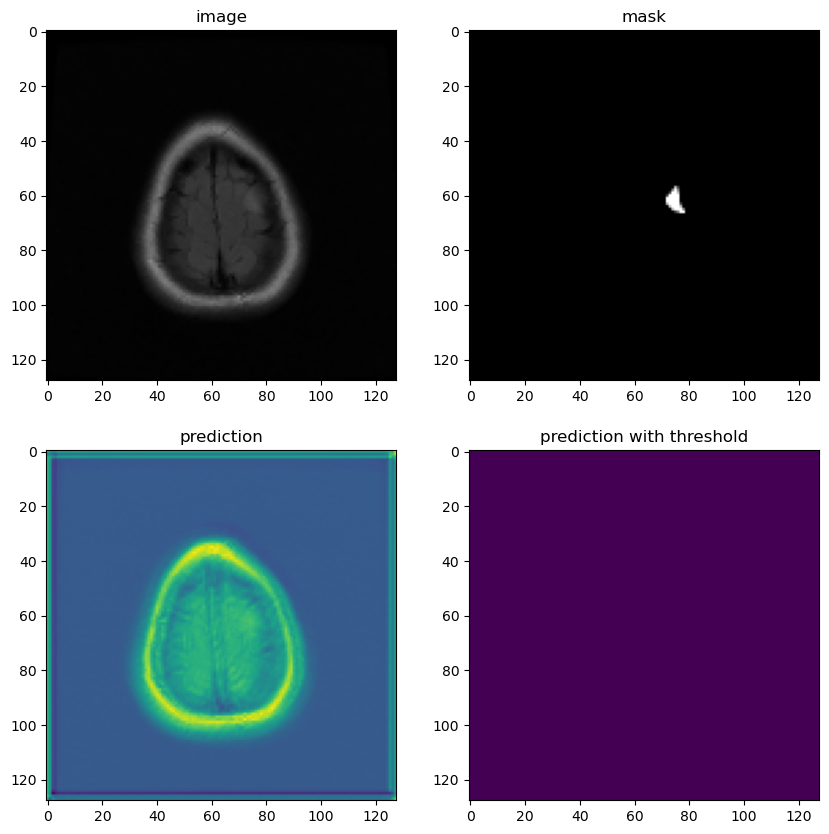

In [37]:
test_sample = test_df[test_df["diagnosis"] == 1].sample(24).values[0]
image = cv2.resize(cv2.imread(test_sample[0]), (128, 128))
mask = cv2.resize(cv2.imread(test_sample[1]), (128, 128))

# Predicted
pred = torch.tensor(image.astype(np.float32) / 255.).unsqueeze(0).permute(0,3,1,2)
pred = tt.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(pred)
pred = model(pred.to(device))
pred = pred.detach().cpu().numpy()[0,0,:,:]

pred_t = np.copy(pred)
pred_t[np.nonzero(pred_t < 0.3)] = 0.0
pred_t[np.nonzero(pred_t >= 0.3)] = 255.
pred_t = pred_t.astype("uint8")

# Plot
fig, ax = plt.subplots(nrows=2,  ncols=2, figsize=(10, 10))

ax[0, 0].imshow(image)
ax[0, 0].set_title("image")
ax[0, 1].imshow(mask)
ax[0, 1].set_title("mask")
ax[1, 0].imshow(pred)
ax[1, 0].set_title("prediction")
ax[1, 1].imshow(pred_t)
ax[1, 1].set_title("prediction with threshold")
plt.show()